### from SAV to LOVE

# HW №5

## Введение в обработку естественного языка
### Урок 5. Part-of-Speech разметка, NER, извлечение отношений

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# !pip install pyconll

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyconll

import nltk
from nltk.corpus import brown
from nltk.tag import DefaultTagger
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger, TrigramTagger
from nltk.tag import RegexpTagger

### Загрузка данных

In [7]:
# !mkdir datasets

In [8]:
# !wget -O ./datasets/ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
# !wget -O ./datasets/ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

In [7]:
full_train = pyconll.load_from_file('datasets/ru_syntagrus-ud-train.conllu')
full_test = pyconll.load_from_file('datasets/ru_syntagrus-ud-dev.conllu')

In [8]:
def get_data(dataset):
    data = []
    for sent in dataset:
        for token in sent:
            data.append((token.form.lower(), token.upos))           
    return data

In [9]:
train_data = get_data(full_train) 
train_data[:7]

[('анкета', 'NOUN'),
 ('.', 'PUNCT'),
 ('начальник', 'NOUN'),
 ('областного', 'ADJ'),
 ('управления', 'NOUN'),
 ('связи', 'NOUN'),
 ('семен', 'PROPN')]

In [10]:
test_data = get_data(full_test) 
test_data[:7]

[('алгоритм', 'NOUN'),
 (',', 'PUNCT'),
 ('от', 'ADP'),
 ('имени', 'NOUN'),
 ('учёного', 'NOUN'),
 ('аль', 'PART'),
 ('-', 'PUNCT')]

In [11]:
len(train_data)

871526

In [12]:
len(test_data)

118692

### Практическое задание 1

**Написать теггер на данных с руским языком**

### 1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбинации  

In [13]:
# Комбинация тэггеров
# Примущество Backoff Tagging в том, что если текущий тэггер не знает, как тэггировать слово, 
# он передает это следующему и так далее, пока не пройдет перебор по всем тэггерам. 
# В данному случае тэггирование производит последовательность UnigramTagger, BigramTagger, TrigramTagger. 
# Комбинация тэггеров дала немного лучший результат, чем UnigramTagger, BigramTagger по отдельности.
def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff

In [19]:
tts = 0.25 # train_test_split
models = []

models.append(('UnigramTagger', UnigramTagger([train_data[:int(len(train_data) * tts)]])))
models.append(('BigramTagger', BigramTagger([train_data[:int(len(train_data) * tts)]])))
models.append(('TrigramTagger', TrigramTagger([train_data[:int(len(train_data) * tts)]])))
models.append(('CombineTagger', backoff_tagger([train_data[:int(len(train_data) * tts)]], [UnigramTagger, BigramTagger, TrigramTagger])))

In [20]:
results = []

for name, model in models:
    accuracy = model.evaluate([test_data])
    results.append((name, accuracy))
  
best_tagger = pd.DataFrame(results, columns = ['model','accuracy'])
best_tagger.sort_values('accuracy', ascending=False)

,model,accuracy
3,CombineTagger,0.812751
0,UnigramTagger,0.807704
1,BigramTagger,0.575388
2,TrigramTagger,0.020347


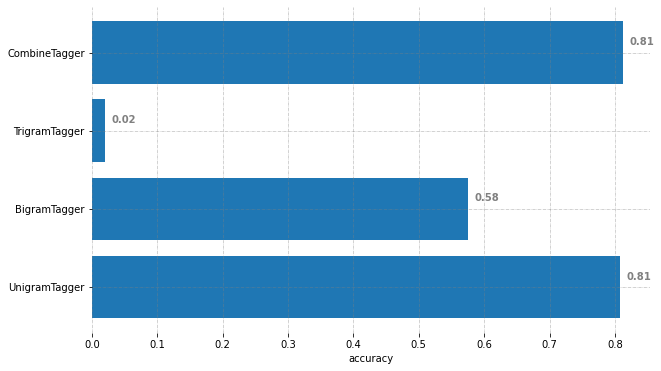

In [22]:
x = best_tagger['model']
y = best_tagger['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

### 2. написать свой теггер как на занятии, но улучшить попробовать разные векторайзеры, добавить знание не только букв и слов но и совместно объединить эти признаки  

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [7]:
classifier = LogisticRegression()

In [25]:
def split_token_label(data):
  tokens = []
  labels = []

  for token, label in data:
    tokens.append(token)
    labels.append('NO_TAG' if label is None else label)

  return tokens, labels

In [26]:
train_tok, train_label = split_token_label(train_data)
train_tok[:5], train_label[:5]

(['анкета', '.', 'начальник', 'областного', 'управления'],
 ['NOUN', 'PUNCT', 'NOUN', 'ADJ', 'NOUN'])

In [27]:
test_tok, test_label = split_token_label(test_data)
test_tok[:5], test_label[:5]

(['алгоритм', ',', 'от', 'имени', 'учёного'],
 ['NOUN', 'PUNCT', 'ADP', 'NOUN', 'NOUN'])

In [28]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)

In [29]:
test_enc_labels = le.transform(test_label)

In [30]:
le.classes_

array(['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
       'NO_TAG', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM',
       'VERB', 'X'], dtype='<U6')

In [77]:
models = []

models.append(('CountVectorizer_word', CountVectorizer(ngram_range=(1,5),analyzer='word', max_features=100)))
models.append(('TfidfVectorizer_word', TfidfVectorizer(ngram_range=(1,5),analyzer='word', max_features=100)))
models.append(('HashingVectorizer_word', HashingVectorizer(ngram_range=(1, 5), analyzer='word', n_features=100)))
models.append(('CountVectorizer_char', CountVectorizer(ngram_range=(1,5), analyzer='char', max_features=100)))
models.append(('TfidfVectorizer_char', TfidfVectorizer(ngram_range=(1,5), analyzer='char', max_features=100)))
models.append(('HashingVectorizer_char', HashingVectorizer(ngram_range=(1, 5), analyzer='char', n_features=100)))
models.append(('CountVectorizer_char_wb', CountVectorizer(ngram_range=(1,5), analyzer='char_wb', max_features=100)))
models.append(('TfidfVectorizer_char_wb', TfidfVectorizer(ngram_range=(1,5), analyzer='char_wb', max_features=100)))
models.append(('HashingVectorizer_char_wb', HashingVectorizer(ngram_range=(1, 5), analyzer='char_wb', n_features=100)))

In [78]:
results = []

for name, model in models:
    X_train = model.fit_transform(train_tok)
    X_test = model.transform(test_tok)
    
    classifier.fit(X_train, train_enc_labels)
    predictions = classifier.predict(X_test)
    
    accuracy = accuracy_score(test_enc_labels, predictions)

    results.append((name, accuracy))
    
best_vectorizer = pd.DataFrame(results, columns = ['model','accuracy'])
best_vectorizer.sort_values('accuracy', ascending=False)

,model,accuracy
7,TfidfVectorizer_char_wb,0.777474
3,CountVectorizer_char,0.776969
6,CountVectorizer_char_wb,0.774981
4,TfidfVectorizer_char,0.774711
8,HashingVectorizer_char_wb,0.733327
5,HashingVectorizer_char,0.685455
0,CountVectorizer_word,0.382081
1,TfidfVectorizer_word,0.382081
2,HashingVectorizer_word,0.288326


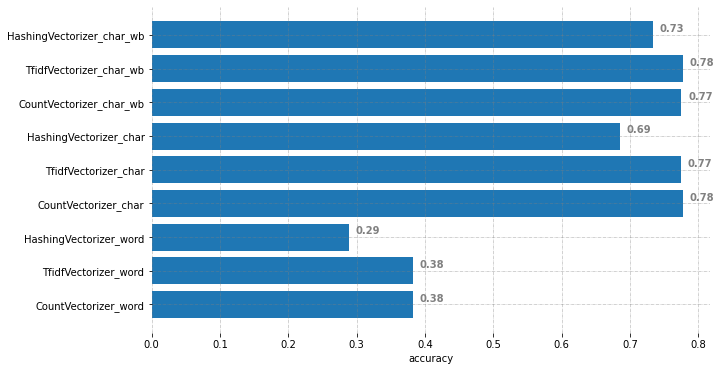

In [79]:
x = best_vectorizer['model']
y = best_vectorizer['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

### 3. вместо векторайзеров взять эмбединги попробовать (word2vec и fasttext по желанию дополнительно можно взять tf.keras.layers.Embedding)  


### 4. взять не только эмбединги каждого слова, но и взять соседей, т.е. информацию о соседях количество соседей выбрать самим (узнать наилучшее количество соседей)    

In [8]:
import multiprocessing
from gensim.models import Word2Vec, FastText

In [43]:
# The parameters:
# min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
# window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
# size = int - Dimensionality of the feature vectors. - (50, 300)
# sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
# alpha = float - The initial learning rate - (0.01, 0.05)
# min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
# negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
# workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [44]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [50]:
results = []

for window in (3, 5, 7, 9, 11, 13, 15, 17):
  for name, model in {'Word2Vec': Word2Vec(sentences=[train_tok + test_tok], size=300, window=window, min_count=1, workers=cores-1), 
                      'FastText': FastText(sentences=[train_tok + test_tok], size=300, window=window, min_count=1, workers=cores-1)}.items():

    X_train = np.array([model[word] for word in train_tok])
    X_test = np.array([model[word] for word in test_tok])

    classifier.fit(X_train, train_enc_labels)
    predictions = classifier.predict(X_test)

    accuracy = accuracy_score(test_enc_labels, predictions)
    name = f'{name}_{window}'

    results.append((name, accuracy))

In [51]:
best_embedding = pd.DataFrame(results, columns = ['model','accuracy'])
best_embedding.sort_values('accuracy', ascending=False)

,model,accuracy
15,FastText_17,0.509992
2,Word2Vec_5,0.509116
13,FastText_15,0.508349
1,FastText_3,0.496141
3,FastText_5,0.495105
7,FastText_9,0.491617
10,Word2Vec_13,0.491524
9,FastText_11,0.488795
0,Word2Vec_3,0.484253
5,FastText_7,0.483124


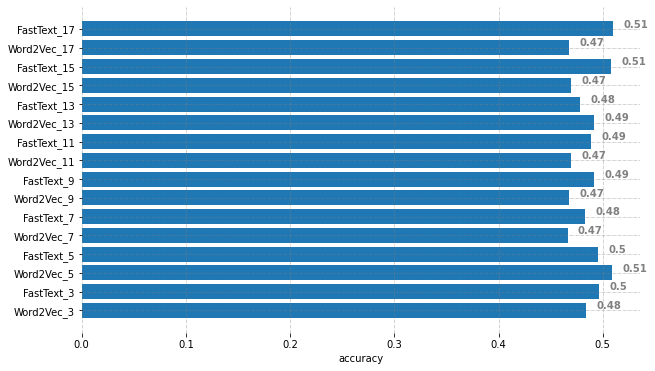

In [52]:
x = best_embedding['model']
y = best_embedding['accuracy']

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

### 5. сравнить все реализованные методы сделать выводы

In [80]:
final_result = pd.concat([best_tagger, best_vectorizer, best_embedding], axis=0)

In [81]:
final_result.sort_values('accuracy', ascending=False)

,model,accuracy
3,CombineTagger,0.812751
0,UnigramTagger,0.807704
7,TfidfVectorizer_char_wb,0.777474
3,CountVectorizer_char,0.776969
6,CountVectorizer_char_wb,0.774981
4,TfidfVectorizer_char,0.774711
8,HashingVectorizer_char_wb,0.733327
5,HashingVectorizer_char,0.685455
1,BigramTagger,0.575388
15,FastText_17,0.509992


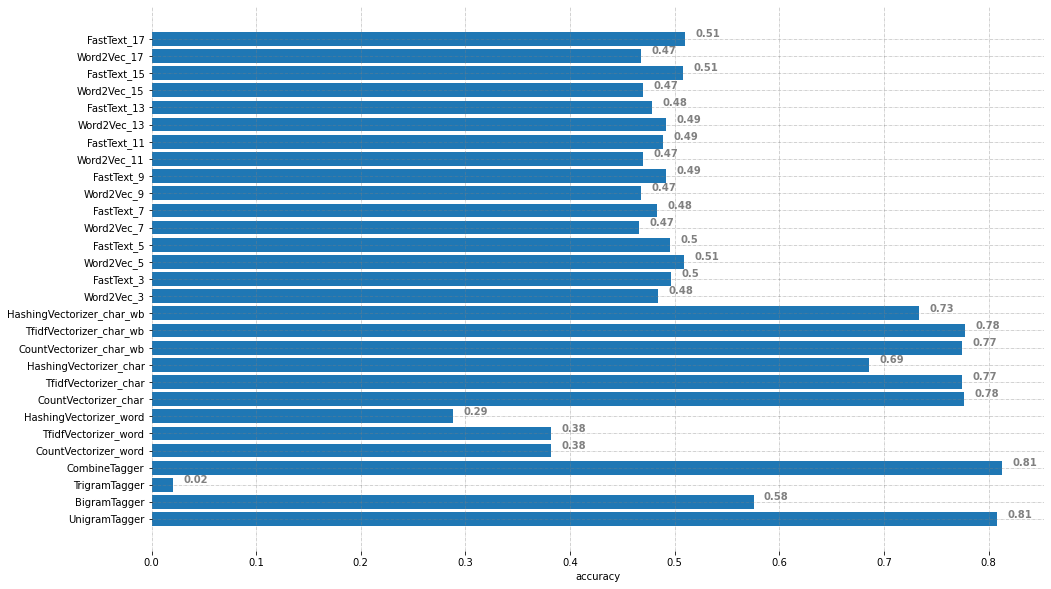

In [82]:
x = final_result['model']
y = final_result['accuracy']

fig, ax = plt.subplots(figsize=(16, 10))
ax.barh(x, y)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.7)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.xlabel('accuracy')
plt.show()

### Практическое задание 2

много дополнительных датасетов на русском языке

https://natasha.github.io/corus/  
https://github.com/natasha/corus

мы будем использовать данные http://ai-center.botik.ru/Airec/index.php/ru/collections/28-persons-1000

**Проверить насколько хорошо работает NER**

при обучении своего нера незабудьте разделить выборку

In [10]:
# !pip install corus
# !pip install razdel
# !wget http://ai-center.botik.ru/Airec/ai-resources/Persons-1000.zip

In [6]:
import corus
from razdel import tokenize

In [7]:
!ls

datasets  Persons-1000.zip    Persons-1000.zip.2
env	  Persons-1000.zip.1  sample_data


In [8]:
path = 'Persons-1000.zip'
records = corus.persons.load_persons(path)
rec = next(records)

In [9]:
rec

PersonsMarkup(
    text='Россия рассчитывает на конструктивное воздействие США на Грузию\r\n\r\n04/08/2008 12:08\r\n\r\nМОСКВА, 4 авг - РИА Новости. Россия рассчитывает, что США воздействуют на Тбилиси в связи с обострением ситуации в зоне грузино-осетинского конфликта. Об этом статс-секретарь - заместитель министра иностранных дел России Григорий Карасин заявил в телефонном разговоре с заместителем госсекретаря США Дэниэлом Фридом.\r\n\r\n"С российской стороны выражена глубокая озабоченность в связи с новым витком напряженности вокруг Южной Осетии, противозаконными действиями грузинской стороны по наращиванию своих вооруженных сил в регионе, бесконтрольным строительством фортификационных сооружений", - говорится в сообщении.\r\n\r\n"Россия уже призвала Тбилиси к ответственной линии и рассчитывает также на конструктивное воздействие со стороны Вашингтона", - сообщил МИД России. ',
    spans=[PersonsSpan(
         id=1,
         start=308,
         stop=324,
         value='ГРИГОРИЙ КАР

In [10]:
rec.text

'Россия рассчитывает на конструктивное воздействие США на Грузию\r\n\r\n04/08/2008 12:08\r\n\r\nМОСКВА, 4 авг - РИА Новости. Россия рассчитывает, что США воздействуют на Тбилиси в связи с обострением ситуации в зоне грузино-осетинского конфликта. Об этом статс-секретарь - заместитель министра иностранных дел России Григорий Карасин заявил в телефонном разговоре с заместителем госсекретаря США Дэниэлом Фридом.\r\n\r\n"С российской стороны выражена глубокая озабоченность в связи с новым витком напряженности вокруг Южной Осетии, противозаконными действиями грузинской стороны по наращиванию своих вооруженных сил в регионе, бесконтрольным строительством фортификационных сооружений", - говорится в сообщении.\r\n\r\n"Россия уже призвала Тбилиси к ответственной линии и рассчитывает также на конструктивное воздействие со стороны Вашингтона", - сообщил МИД России. '

In [11]:
rec.spans

[PersonsSpan(
     id=1,
     start=308,
     stop=324,
     value='ГРИГОРИЙ КАРАСИН'
 ), PersonsSpan(
     id=2,
     start=387,
     stop=402,
     value='ДЭНИЭЛ ФРИД'
 )]

In [12]:
word_tag = []

for rec in records:
  for r in rec.spans:
    for t in tokenize(rec.text):
      if (t.start >= r.start) and (t.stop <= r.stop):
        word_tag.append((rec.text[t.start:t.stop], 'PERSON'))
      else:
        word_tag.append((rec.text[t.start:t.stop], 'NO_PERSON'))

print(word_tag[:7])

[('Комиссар', 'NO_PERSON'), ('СЕ', 'NO_PERSON'), ('критикует', 'NO_PERSON'), ('ограничительную', 'NO_PERSON'), ('политику', 'NO_PERSON'), ('в', 'NO_PERSON'), ('отношении', 'NO_PERSON')]


### 1. взять нер из nltk

С помощью функции nltk.ne_chunk () мы можем распознавать именованные сущности с помощью классификатора, который добавляет метки категорий, такие как PERSON, ORGANIZATION и GPE.

In [13]:
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('names')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [14]:
print(len(word_tag))

3715842


In [24]:
tts = 0.25 # train_test_split

In [101]:
{(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(word_tag[:int(len(word_tag) * tts)]) if hasattr(chunk, 'label') }

{('AP', 'ORGANIZATION'),
 ('CSSD', 'ORGANIZATION'),
 ('Clinton', 'PERSON'),
 ('HSBC', 'ORGANIZATION'),
 ('John', 'PERSON'),
 ('John Huntsman Jr', 'PERSON'),
 ('John Roos', 'PERSON'),
 ('KSCM', 'ORGANIZATION'),
 ('New York', 'GPE'),
 ('Washington', 'GPE'),
 ('Washington Post', 'ORGANIZATION'),
 ('ГМИИ', 'ORGANIZATION'),
 ('ЛДПР', 'ORGANIZATION'),
 ('МВД', 'ORGANIZATION'),
 ('ОПЕК', 'ORGANIZATION'),
 ('ПЕТЕРБУРГ', 'ORGANIZATION'),
 ('САО', 'ORGANIZATION')}

### 2. проверить deeppavlov

In [19]:
# # установка deeppavlov
# !python -m venv env 
# !pip install deeppavlov
# !python -m deeppavlov install squad_bert
# !python -m deeppavlov install ner_ontonotes

In [15]:
# import deeppavlov
# from deeppavlov import configs, build_model

In [20]:
# deeppavlov_ner = build_model(configs.ner.ner_bert_ent_and_type_rus, download=True)

In [21]:
# tts = 0.01 # train_test_split

In [ ]:
# deeppavlov_ner(word_tag[:int(len(word_tag) * tts)])

### 3. написать свой нер попробовать разные подходы (с доп информацией без) так же с учётом соседей и без них

In [ ]:
# def split_token_label(data):
#   tokens = []
#   labels = []

#   for token, label in data:
#     tokens.append(token)
#     labels.append('NO_TAG' if label is None else label)

#   return tokens, labels

In [35]:
X = []
y = []

for token, label in word_tag:
    X.append(token)
    y.append(label)

X[:5], y[:5]

(['Комиссар', 'СЕ', 'критикует', 'ограничительную', 'политику'],
 ['NO_PERSON', 'NO_PERSON', 'NO_PERSON', 'NO_PERSON', 'NO_PERSON'])

In [21]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(y)

In [22]:
print(le.classes_)

['NO_PERSON' 'PERSON']


In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, train_enc_labels)

In [32]:
models = []

models.append(('CountVectorizer_word', CountVectorizer(ngram_range=(1,5),analyzer='word', max_features=100)))
models.append(('TfidfVectorizer_word', TfidfVectorizer(ngram_range=(1,5),analyzer='word', max_features=100)))
models.append(('HashingVectorizer_word', HashingVectorizer(ngram_range=(1, 5), analyzer='word', n_features=100)))
models.append(('CountVectorizer_char', CountVectorizer(ngram_range=(1,5), analyzer='char', max_features=100)))
models.append(('TfidfVectorizer_char', TfidfVectorizer(ngram_range=(1,5), analyzer='char', max_features=100)))
models.append(('HashingVectorizer_char', HashingVectorizer(ngram_range=(1, 5), analyzer='char', n_features=100)))
models.append(('CountVectorizer_char_wb', CountVectorizer(ngram_range=(1,5), analyzer='char_wb', max_features=100)))
models.append(('TfidfVectorizer_char_wb', TfidfVectorizer(ngram_range=(1,5), analyzer='char_wb', max_features=100)))
models.append(('HashingVectorizer_char_wb', HashingVectorizer(ngram_range=(1, 5), analyzer='char_wb', n_features=100)))

In [33]:
results = []

for name, model in models:
    X_train_vec = model.fit_transform(X_train)
    X_test_vec = model.transform(X_test)
    
    classifier.fit(X_train_vec, y_train)
    predictions = classifier.predict(X_test_vec)
    
    accuracy = accuracy_score(y_test, predictions)

    results.append((name, accuracy))
    
best_ner = pd.DataFrame(results, columns = ['model','accuracy'])
best_ner.sort_values('accuracy', ascending=False)

,model,accuracy
0,CountVectorizer_word,0.994357
1,TfidfVectorizer_word,0.994357
2,HashingVectorizer_word,0.994357
3,CountVectorizer_char,0.994357
4,TfidfVectorizer_char,0.994357
5,HashingVectorizer_char,0.994357
6,CountVectorizer_char_wb,0.994357
7,TfidfVectorizer_char_wb,0.994357
8,HashingVectorizer_char_wb,0.994357


### 4. сделать выводы по вашим экспериментам какой из подходов успешнее справляется